In [91]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 20 11:31:32 2022
 
@author: ktjonasam
"""
 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from itertools import chain, repeat, count, islice
import itertools
from tqdm import tqdm
import statistics

#import os
#os.chdir(r"X:\Sales\Maier Models\Py Tools\MC_Scott")
 


In [58]:
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=2180)
 
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData=yf.download(stocks,start,end,threads=True)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix
 
import_stock_list_raw=pd.read_excel('/Users/loganheft/Desktop/Thematic.xlsx',parse_dates=True)
 
 
#Stocklist filtered for ETF that have a 5 year track list
stock_list_filtered=import_stock_list_raw[(import_stock_list_raw['ETF Inception Date']<'01-01-2018')]
 
stock_list_filtered
 


,Ticker,Name,ETF Inception Date,Thematic Category,5YR Return
8,GII,SPDR S&P Global Infrastructure ETF,2007-01-25,Infrastructure Development,3.24844
15,XBI,SPDR S&P BIOTECH ETF,2006-01-31,Health - Biotech and Genomics,-0.353
16,VEGI,iShares MSCI Global Agriculture Producers ETF,2012-01-31,AgTech & Food Innovation,9.73002
21,IBB,iShares Biotechnology ETF,2001-02-05,Health - Biotech and Genomics,4.46181
22,QCLN,First Trust Nasdaq Clean Edge Green Energy Ind...,2007-02-08,CleanTech,19.07499
...,...,...,...,...,...
238,HAIL,SPDR S&P Kensho Smart Mobility ETF,2017-12-26,Mobility - Electric and Autonomous Vehicles,1.3125
239,SIMS,SPDR S&P Kensho Intelligent Structures ETF,2017-12-26,Infrastructure Development,2.72356
240,FITE,SPDR S&P Kensho Future Security ETF,2017-12-26,Broad Thematic,8.54425
244,DTEC,ALPS Disruptive Technologies ETF,2017-12-29,Broad Thematic,5.98302


# 5yr Single Point Portfolio (No replacement)

In [96]:
#Generate portfolio Reutrns using single point 5yr (Annualized Total Returns)
#n_portfolios=10000
n_portfolios=5
set_port_returns=pd.DataFrame()
portfolio_dict={}
for i in range(n_portfolios):
    # time.sleep(1)
    stocklist=list(np.random.choice(stock_list_filtered['Ticker'],4))
    print(stocklist)
    
    portfolio_name="Portfolio {0}".format(i)
    portfolio_dict[portfolio_name] = stocklist
    temp_select_tickers=stock_list_filtered[["Ticker","5YR Return"]].loc[stock_list_filtered["Ticker"].isin(stocklist)]
    temp_select_tickers['Weights']=.25
    
    portfolio_returns=np.cumprod(np.inner(temp_select_tickers["5YR Return"],temp_select_tickers['Weights']))
    portfolio_returns_str=(str(portfolio_returns).lstrip('[').rstrip(']'))
    print(f'{portfolio_returns_str}%') 
    
    temp=pd.DataFrame([portfolio_name,float(portfolio_returns)]).T
    set_port_returns=pd.concat([set_port_returns,temp],axis=0)
    print('')
    

set_port_returns.columns=(["Port_Name",'Returns'])
set_port_returns=set_port_returns.sort_values(by=['Returns'],ascending=False)
print(set_port_returns)
print('')
hit_Rate=(len(set_port_returns[set_port_returns['Returns']>0])/n_portfolios)*100
port_single_point_mean=set_port_returns['Returns'].mean().round(3)
median=round(statistics.median(set_port_returns['Returns']),3)
minimum=round(min(set_port_returns['Returns']),3)
maximum=round(max((set_port_returns['Returns'])),3)
port_std_dev=np.std(set_port_returns['Returns']).round(3)

print(f'{hit_Rate}% of portfolios return positive results')
print(f'The average return of the randomly generated portfolios was {port_single_point_mean}%')  
print(f'The median return of the randomly generated portfolios was {median}%')
print(f'The portfolio with the lowest return was {minimum}%')
print(f'The portfolio with the highest return was {maximum}%')
print(f'The standard deviation of all the portfolios is {port_std_dev}%')
 
 


['INCO', 'PXQ', 'IGF', 'IBUY']
3.4552925%

['MOO', 'SMOG', 'PHO', 'RNRG']
9.28335%

['ARKG', 'AGNG', 'BOTZ', 'KEMQ']
-0.2244075%

['RNRG', 'AGNG', 'EVX', 'IVES']
4.2142675%

['ECON', 'BBP', 'IPAY', 'CGW']
2.0457525%

     Port_Name   Returns
0  Portfolio 1   9.28335
0  Portfolio 3  4.214268
0  Portfolio 0  3.455293
0  Portfolio 4  2.045752
0  Portfolio 2 -0.224408

80.0% of portfolios return positive results
The average return of the randomly generated portfolios was 3.755%
The median return of the randomly generated portfolios was 3.455%
The portfolio with the lowest return was -0.224%
The portfolio with the highest return was 9.283%
The standard deviation of all the portfolios is 3.15%


Average Portfolio Hit Rate is 8000.0% After 5 Portfolio Simulations
Average Portfolio Returns is 3.755% After 5 Portfolio Simulations


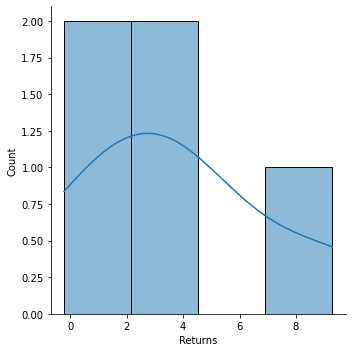

In [97]:
sns.displot(set_port_returns['Returns'],kde=True)
 
# Displaying the averages --- You can positions this at the end of the script
print("Average Portfolio Hit Rate is " + str(hit_Rate*100) +"% After " +str(n_portfolios) +" Portfolio Simulations")
print("Average Portfolio Returns is " + str(port_single_point_mean.round(3)) +"% After " +str(n_portfolios) +" Portfolio Simulations")
 
######## MC Simulation utilizing Daily Returns ######

In [8]:
#### Generate the Data for the MC Daily returns
stock_list_mc=list(stock_list_filtered['Ticker']) #### This reads from the set or portoflio iterations
stockData=yf.download(stock_list_mc,startDate,endDate,threads=True)
stockData = stockData['Close']

[*********************100%***********************]  78 of 78 completed


#  MonteCarlo Simulation 

Portfolio 0
       Portfolio 0   Portfolio 1   Portfolio 2   Portfolio 3   Portfolio 4  \
0      9705.921736  10073.398939   9966.962924  10060.054523  10074.923013   
1      9310.052198  10400.022916   9943.511041   9930.329750   9937.798675   
2      9706.143165   9960.860748   9986.226545   9883.225291   9998.351619   
3      9797.257301   9940.390107   9961.791364   9835.357108   9819.426248   
4      9962.716721   9824.800427   9904.246647   9698.412805   9681.594379   
...            ...           ...           ...           ...           ...   
1820  17692.433057   8732.316886  11901.003801  12098.572358  18838.685395   
1821  17890.069131   8834.129818  12196.639213  12316.158924  18923.818079   
1822  18247.698494   9039.125092  12136.123208  12411.328989  18865.550571   
1823  17692.430811   9048.677592  12212.950931  12468.083764  18789.563728   
1824  18003.172688   8908.936567  12155.058632  12383.147747  18623.280655   

       Portfolio 0   Portfolio 1  Portfolio 2   Por

/var/folders/_3/nycg9ml5253c_md6q7nhx8x80000gn/T/ipykernel_28566/3484567457.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portfolio_ratios = portfolio_ratios.append({'Portfolio': portfolio_name, 'Sharpe Ratio': sharpe_ratio, 'Average Return':average_return, 'Standard Deviation':std_return, 'Range of Returns':range_return, 'Median Return':median_return}, ignore_index=True)
/var/folders/_3/nycg9ml5253c_md6q7nhx8x80000gn/T/ipykernel_28566/3484567457.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portfolio_ratios = portfolio_ratios.append({'Portfolio': portfolio_name, 'Sharpe Ratio': sharpe_ratio, 'Average Return':average_return, 'Standard Deviation':std_return, 'Range of Returns':range_return, 'Median Return':median_return}, ignore_index=True)
/var/folders/_3/nycg9ml5253c_md6q7nhx8x80000gn/T/ipykernel

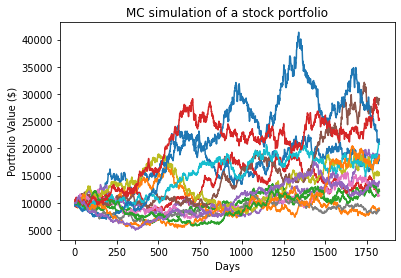

     Portfolio  Sharpe Ratio  Average Return  Standard Deviation  \
0  Portfolio 0      2.394658    21648.747530         9040.422759   
1  Portfolio 1      2.563369    10128.718128         3951.319295   
2  Portfolio 2      4.451079     9435.601628         2119.839334   
3  Portfolio 3      3.753507    20304.073599         5409.352804   
4  Portfolio 4      3.330041    10308.923951         3095.725706   

   Range of Returns  Median Return  
0      34384.074399   22978.690151  
1      15069.543496    9305.184132  
2       7649.747412    9783.808255  
3      20015.402472   22147.646701  
4      12560.967060   10044.065151  


In [16]:
# Define the risk-free rate
risk_free_rate = 0.03

# Create an empty DataFrame to store the portfolio names and Sharpe ratios
portfolio_ratios = pd.DataFrame(columns=['Portfolio', 'Sharpe Ratio','Average Return','Standard Deviation','Range of Returns','Median Return'])

for portfolio_name, portoflio_holdings in portfolio_dict.items():
    try:
        print (portfolio_name)
        stock_list=portfolio_dict[portfolio_name]
        returns = stockData[stock_list].pct_change()
        
        meanReturns = returns.mean()
        covMatrix = returns.cov()
        corrMatrix=returns.corr()
        
        # handling of NaN values
        covMatrix=np.nan_to_num(covMatrix)
        meanReturns = np.nan_to_num(meanReturns)
       
        weights = np.array([.25,.25,.25,.25])
        weights /= np.sum(weights)
       
        # Monte Carlo Method
        T = 365*5 #timeframe in days - Simulates 5 Daily Year Returns (Current Run time is 10it/s)
        
        meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
        meanM = meanM.T
       
        portfolio_sims = np.full(shape=(T, n_portfolios), fill_value=0.0) # This sets up a blank array for the returns for each port iterations
       
        initialPortfolio = 10000
       
        # for m in range(0, mc_sims):
        Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
        L = np.linalg.cholesky(covMatrix)

        dailyReturns = meanM + np.inner(L, Z)
        Port_MC_Sim=portfolio_sims[:,n_portfolios-1] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
        
        # Find the average return
        average_return = np.mean(Port_MC_Sim)
        
        # Find the standard deviation
        std_return = np.std(Port_MC_Sim)
        
        # Find the range of returns
        range_return = (np.max(Port_MC_Sim) - np.min(Port_MC_Sim))
        
        # Find the median return
        median_return = np.median(Port_MC_Sim)
        
        # Calculate Sharpe Ratio
        sharpe_ratio = (average_return - risk_free_rate) / std_return
        
        # Append the portfolio name and ratios to the DataFrame
        portfolio_ratios = portfolio_ratios.append({'Portfolio': portfolio_name, 'Sharpe Ratio': sharpe_ratio, 'Average Return':average_return, 'Standard Deviation':std_return, 'Range of Returns':range_return, 'Median Return':median_return}, ignore_index=True)
        temp_df_for_plot = pd.DataFrame(Port_MC_Sim,columns=[portfolio_name])
        results_for_plots = pd.concat([results_for_plots, temp_df_for_plot],axis=1)
        print(results_for_plots)
    
    except:
        pass
        ### This is to pass for errors within the cov matrix (Exception Raised: Matrix is not positive definite)

plt.plot(results_for_plots)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()   

# Print the resulting DataFrame
print(portfolio_ratios)


# Simulation replacing the worst performer in a portfolio at the end of each year

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
EMQQ is being deleted
['ISHP', 'PBD', 'ROBO', 'FITE']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ISHP is being deleted
['PBD', 'ROBO', 'FITE', 'MOO']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ROBO is being deleted
['PBD', 'FITE', 'MOO', 'SDG']
[************

[*********************100%***********************]  1 of 1 completed
PIO is being deleted
['PHO', 'DTEC', 'TAN', 'BOTZ']
New Portfolio
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
CLIX is being deleted
['INCO', 'EBLU', 'PBE', 'EBLU']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
INCO is being deleted
['EBLU', 'PBE', 'EBLU', 'EBLU']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complete

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
URA is being deleted
['PAVE', 'SMOG', 'AGNG', 'PAVE']
New Portfolio


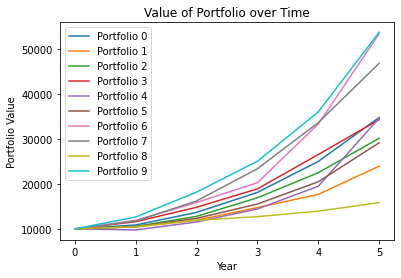

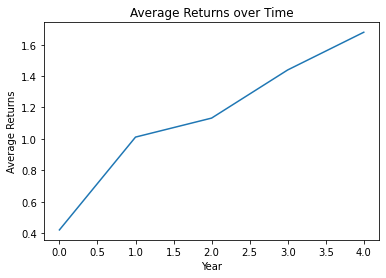

In [78]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n_portfolios = 10
portfolio_returns = {}
tickers=list(stock_list_filtered['Ticker'])

def get_return_for_ticker_in_year(ticker, year):
    # Get stock data for the ticker from Yahoo Finance
    data = yf.download(ticker, start='2018-01-01', end='2022-12-31')

    # Calculate the return for the year
    return_val = (data['Close'][-1] - data['Close'][0]) / data['Close'][0]

    return return_val

# Initialize a list to store the values of each portfolio over time
portfolio_values_over_time = [[] for _ in range(n_portfolios)]
sum_returns = [0]*5

for i in range(n_portfolios):
    stocklist = list(np.random.choice(tickers, 4))
    portfolio_name = "Portfolio {0}".format(i)
    portfolio_returns[portfolio_name] = {}
    portfolio_value = 10000 # reset the value of the portfolio at the beginning of each iteration 
    portfolio_values_over_time[i].append(portfolio_value)
    for year in range(5):
        returns = []
        for ticker in stocklist:
            # Retrieve the return for each ticker for the current year
            return_val = get_return_for_ticker_in_year(ticker, year)
            returns.append(return_val)
            sum_returns[year] += return_val

        portfolio_returns[portfolio_name][year] = returns
        # Update the portfolio value based on the returns of each stock, giving them equal weighting
        portfolio_value = portfolio_value * (1 + sum(returns) / len(returns))
        portfolio_values_over_time[i].append(portfolio_value)

        # Remove the worst performing ticker
        worst_ticker_index = returns.index(min(returns))
        print(f'{stocklist[worst_ticker_index]} is being deleted')

        stocklist.pop(worst_ticker_index)
        
        # Add a new ticker to the portfolio
        new_ticker = random.choice(tickers)
        stocklist.append(new_ticker)
        tickers.remove(new_ticker)
        print(stocklist)
    print('')
    print('This is a new portfolio')

# Plot the value of the portfolios over time
for i in range(n_portfolios):
    plt.plot(portfolio_values_over_time[i], label=f'Portfolio {i}')
plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.title('Value of Portfolio over Time')
plt.legend()
plt.show()

# calculate the average return
average_returns = [returns/n_portfolios for returns in sum_returns]
# Plot the average returns over time
plt.plot(average_returns)
plt.xlabel('Year')
plt.ylabel('Average Returns')
plt.title('Average Returns over Time')
plt.show()

# Simulation removing and replacing the top performer in each portfolio

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
FITE is being deleted
['MOO', 'DTEC', 'HAIL', 'SIMS']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MOO is being deleted
['DTEC', 'HAIL', 'SIMS', 'SBIO']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DTEC is being deleted
['HAIL', 'SIMS', 'SBIO', 'FIW']
[*********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
FITE is being deleted
['PRNT', 'FINX', 'FINX', 'OBOR']

This is a new portfolio
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
LIT is being deleted
['SNSR', 'HAIL', 'EBLU', 'VEGI']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
VEGI is being deleted
['SNSR', 'HAIL', 'EBLU', 'NLR']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
EBLU is being deleted
['CNCR', 'ECON', 'CNCR', 'ISHP']

This is a new portfolio


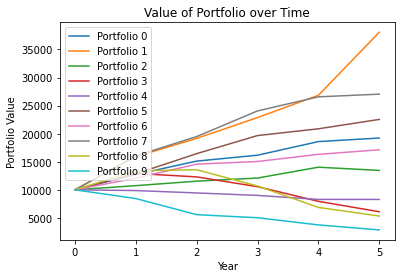

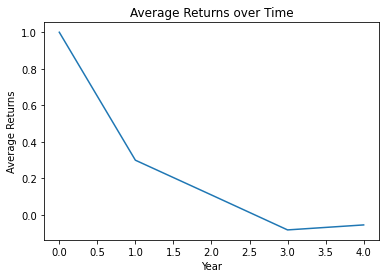

In [79]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n_portfolios = 10
portfolio_returns = {}
tickers=list(stock_list_filtered['Ticker'])

def get_return_for_ticker_in_year(ticker, year):
    # Get stock data for the ticker from Yahoo Finance
    data = yf.download(ticker, start='2018-01-01', end='2022-12-31')

    # Calculate the return for the year
    return_val = (data['Close'][-1] - data['Close'][0]) / data['Close'][0]

    return return_val

# Initialize a list to store the values of each portfolio over time
portfolio_values_over_time = [[] for _ in range(n_portfolios)]
sum_returns = [0]*5

for i in range(n_portfolios):
    stocklist = list(np.random.choice(tickers, 4))
    portfolio_name = "Portfolio {0}".format(i)
    portfolio_returns[portfolio_name] = {}
    portfolio_value = 10000 # reset the value of the portfolio at the beginning of each iteration 
    portfolio_values_over_time[i].append(portfolio_value)
    for year in range(5):
        returns = []
        for ticker in stocklist:
            # Retrieve the return for each ticker for the current year
            return_val = get_return_for_ticker_in_year(ticker, year)
            returns.append(return_val)
            sum_returns[year] += return_val

        portfolio_returns[portfolio_name][year] = returns
        # Update the portfolio value based on the returns of each stock, giving them equal weighting
        portfolio_value = portfolio_value * (1 + sum(returns) / len(returns))
        portfolio_values_over_time[i].append(portfolio_value)

        # Remove the worst performing ticker
        best_ticker_index = returns.index(max(returns))
        print(f'{stocklist[best_ticker_index]} is being deleted')

        stocklist.pop(best_ticker_index)
        
        # Add a new ticker to the portfolio
        new_ticker = random.choice(tickers)
        stocklist.append(new_ticker)
        tickers.remove(new_ticker)
        print(stocklist)
    print('')
    print('This is a new portfolio')

# Plot the value of the portfolios over time
for i in range(n_portfolios):
    plt.plot(portfolio_values_over_time[i], label=f'Portfolio {i}')
plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.title('Value of Portfolio over Time')
plt.legend()
plt.show()

# calculate the average return
average_returns = [returns/n_portfolios for returns in sum_returns]
# Plot the average returns over time
plt.plot(average_returns)
plt.xlabel('Year')
plt.ylabel('Average Returns')
plt.title('Average Returns over Time')
plt.show()